In [1]:
import random
import math


def normal_sample_clt(mean: float, disp: float) -> float:
    """ Generates sample with normal distribution using central limit theorem """

    uniform_sum = sum(random.random() for _ in range(12))
    standard_normal = uniform_sum - 6
    return mean + disp * standard_normal

    
def normal_sample_rejection(mean, dispersion):
    """ Generates sample with normal distribution using rejection sampling """
    while True:
        x = 2 * random.random() - 1
        y = random.random()
        if y < math.exp(-x**2 / 2):
            return mean + dispersion * x


def normal_sample_box_muller(mean: float, disp: float) -> float:
    """ Generates sample with normal distribution using Box-Muller transform """
    u1 = random.random()
    u2 = random.random()

    while u1 == 0:
        u1 = random.random()

    z0 = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
    return mean + disp * z0


====== normal_sample_clt ======
Average time: 987.93 ns/sample
Target mean: 0.00, Sample mean: 0.05
Target std: 5.00, Sample std: 4.98
Target var: 25.00, Sample var: 24.84


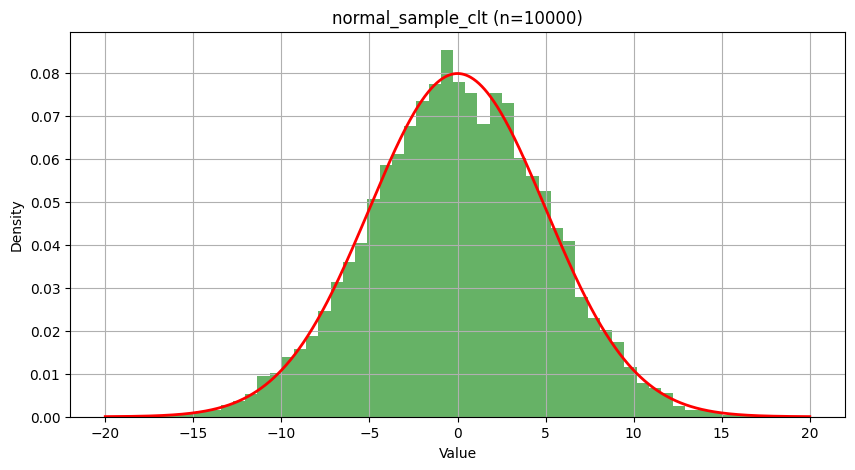


====== normal_sample_rejection ======
Average time: 350.55 ns/sample
Target mean: 0.00, Sample mean: 0.04
Target std: 5.00, Sample std: 2.71
Target var: 25.00, Sample var: 7.34


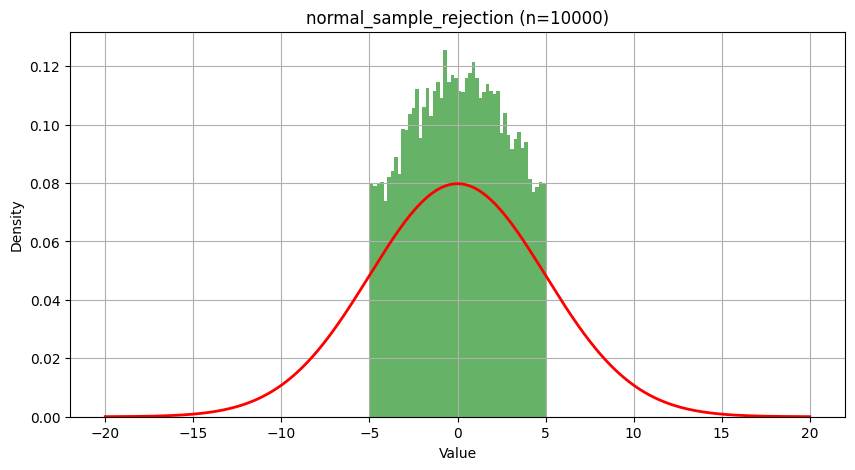


====== normal_sample_box_muller ======
Average time: 381.56 ns/sample
Target mean: 0.00, Sample mean: -0.06
Target std: 5.00, Sample std: 5.04
Target var: 25.00, Sample var: 25.43


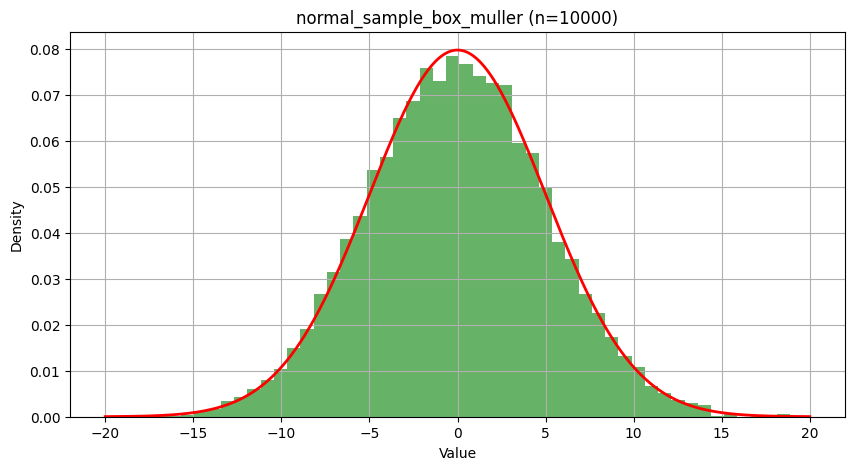


====== normal ======
Average time: 598.22 ns/sample
Target mean: 0.00, Sample mean: -0.05
Target std: 5.00, Sample std: 5.00
Target var: 25.00, Sample var: 24.96


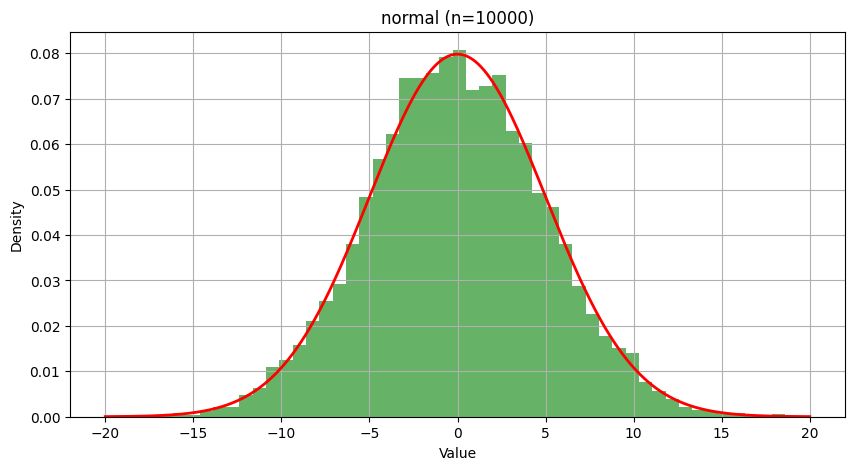

In [2]:
from matplotlib import pyplot as plt
from time import perf_counter_ns
import numpy as np
from scipy.stats import norm


def calculate_stats(samples):
    """Calculate statistics without scipy"""
    n = len(samples)
    mean = sum(samples)/n
    variance = sum((x-mean)**2 for x in samples)/n
    std_dev = math.sqrt(variance)
    return mean, variance, std_dev


def test_sampling_algo(rng_algo, mean=0, disp=5, num_samples=10000):
    samples = []
    
    start = perf_counter_ns()
    for _ in range(num_samples):
        samples.append(rng_algo(mean, disp))
    elapsed_ns = perf_counter_ns() - start
    
    sample_mean, sample_var, sample_std = calculate_stats(samples)
    
    print(f"\n====== {rng_algo.__name__} ======")
    print(f"Average time: {elapsed_ns/num_samples:.2f} ns/sample")
    print(f"Target mean: {mean:.2f}, Sample mean: {sample_mean:.2f}")
    print(f"Target std: {disp:.2f}, Sample std: {sample_std:.2f}")
    print(f"Target var: {disp**2:.2f}, Sample var: {sample_var:.2f}")
    
    plt.figure(figsize=(10, 5))
    
    hist, bins, _ = plt.hist(samples, bins=50, density=True, alpha=0.6, color='g')
    x = np.linspace(mean - 4*disp, mean + 4*disp, 1000)
    pdf = [norm.pdf(val, mean, disp) for val in x]
    plt.plot(x, pdf, 'r-', lw=2)
    
    plt.title(f"{rng_algo.__name__} (n={num_samples})")
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()
    

test_sampling_algo(normal_sample_clt)
test_sampling_algo(normal_sample_rejection)
test_sampling_algo(normal_sample_box_muller)
test_sampling_algo(np.random.normal)


In [3]:
import glm
import math


def sample_motion_model(u: glm.vec3, pos: glm.vec3, noise: glm.vec4) -> glm.vec3:
    delta_r1 = u.x + normal_sample_box_muller(0, noise[0] * abs(u.x) + noise[1] * u.z)
    delta_r2 = u.y + normal_sample_box_muller(0, noise[0] * abs(u.y) + noise[1] * u.z)
    delta_trans = u.z + normal_sample_box_muller(0, noise[2] * u.z + noise[3] * (abs(u.x) + abs(u.y)))
    
    pred_x = pos.x + delta_trans * math.cos(pos.z + delta_r1)
    pred_y = pos.y + delta_trans * math.sin(pos.z + delta_r1)
    pred_theta = pos.z + delta_r1 + delta_r2
    return glm.vec3(pred_x, pred_y, pred_theta)

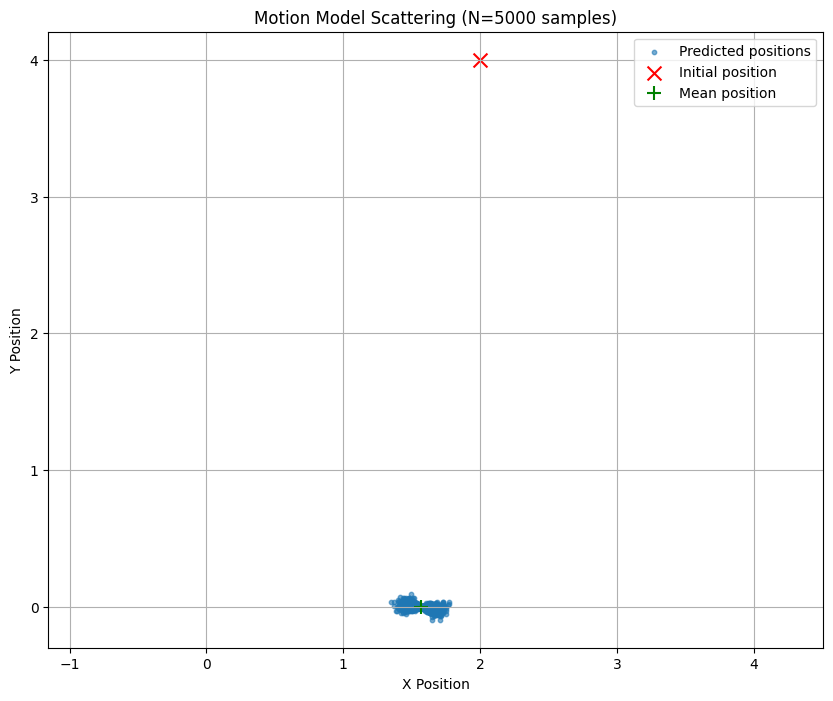

In [4]:
pos = glm.vec3(
    2.0,
    4.0,
    0.0
)
u = glm.vec3(
    math.pi / 2,
    0.0,
    1.0
)
noise = (
    0.1,
    0.1,
    0.01,
    0.01
)
N = 5000

points = []
for _ in range(N):
    points.append(sample_motion_model(pos, u, noise))
points = np.array(points)

plt.figure(figsize=(10, 8))
    
plt.scatter(points[:, 0], points[:, 1], alpha=0.6, s=10, label='Predicted positions')

plt.scatter(pos.x, pos.y, c='red', s=100, marker='x', label='Initial position')

mean_x, mean_y, _ = np.mean(points, axis=0)
plt.scatter(mean_x, mean_y, c='green', s=100, marker='+', label='Mean position')

plt.title(f'Motion Model Scattering (N={N} samples)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

Пусть робота движется по круговой траектории с постоянной поступательной и угловой скоростями $V$ и $\omega$. Текущее положение робота - $(x, y, \theta)$.\
***1) Выведите выражение для центра окружности $(x_c, y_c)$.***\
Угловая скорость $\omega = \frac{V}{R}$. Получим радиус $R = \frac{V}{\omega}$. Угол $\theta$ всегда перпендикулярен прямой из центра окружности к текущему положению робота (Точка А). Запишем угол прямой как $\alpha$. В ЛСК из центра круга, положение робота 
$$\begin{pmatrix} x \\ y \end{pmatrix} - \begin{pmatrix} x_c \\ y_c\end{pmatrix} = \begin{pmatrix} R \cdot cos(\alpha) \\ R \cdot sin(\alpha) \end{pmatrix} $$
$$ \alpha = \theta + \frac{\pi}{2} $$
$$\begin{pmatrix} x \\ y \end{pmatrix} - \begin{pmatrix} x_c \\ y_c\end{pmatrix} = \begin{pmatrix} R \cdot -\sin\theta \\ R \cdot \cos \theta \end{pmatrix} $$
Так, получаем:
$$\begin{pmatrix} x_c \\ y_c\end{pmatrix} = \begin{pmatrix} x \\ y \end{pmatrix} + \begin{pmatrix} - \frac{V}{\omega} \cdot \sin\theta \\ \frac{V}{\omega} \cdot \cos \theta \end{pmatrix} $$

Пусть известны начальное $(x, y, \theta)$ и конечное $(x', y', \theta')$ положения робота, "соединенные" движением по окружности.\
***2. Выведите выражение для центра окружности.***\
Возьмем точку $P$, находящуюся на середине между точками $P_1(x, y, \theta)$ и $P_2(x', y', \theta')$. Координаты этой точки могут быть выражены как:
$$P=\frac{1}{2}\begin{pmatrix} x + x' \\ y + y' \end{pmatrix} $$
Тогда, центр окружности будет 
Далее, рассмотрим вектор $\vec{P_1P_2}$. Направление вектора выражается как $\begin{pmatrix} x' - x \\ y' + y \end{pmatrix}$. Повернем вектор на 90 градусов с помощью матрицы поворота, получается 

Поворот вектора $\begin{pmatrix} a \\ b \end{pmatrix}$ на $90^\circ$ против часовой стрелки:
$$\begin{pmatrix} 0 & -1 \\ 1 & 0 \end{pmatrix} \begin{pmatrix} a \\ b \end{pmatrix} = \begin{pmatrix} -b \\ a \end{pmatrix}$$
Тогда, используя вектор направления из средней точки к центру окружности может быть задано параметрически положение центра:
$$\begin{pmatrix} x_c \\ y_c \end{pmatrix} = \frac{1}{2}\begin{pmatrix} x + x' \\ y + y' \end{pmatrix} + \mu \begin{pmatrix} y - y' \\ x' - x \end{pmatrix} $$


***3. Выразите значение $\mu$:***

Рассмотрим вектор $\vec{AC}$ соединяющий первую точку с центром окружности:
$$\vec{AC} = \begin{pmatrix} x_c - x \\ y_c - y \end{pmatrix} = \frac{1}{2}\begin{pmatrix} x + x' \\ y + y' \end{pmatrix} + \mu \begin{pmatrix} y - y' \\ x' - x \end{pmatrix} - \begin{pmatrix} x \\ y \end{pmatrix} = \frac{1}{2}\begin{pmatrix} x' - x \\ y' - y \end{pmatrix} + \mu \begin{pmatrix} y - y' \\ x' - x \end{pmatrix}$$
При этом, направление полученного вектора должно быть перпендикулярно направлению робота в данной точке $\vec{h} = \begin{pmatrix} \cos \theta \\ \sin\theta \end{pmatrix}$
Запишем условие перпендикулярности через скалярное произведение:
$$\vec{AC}\cdot\vec{h} = 0$$
$$(\frac{x' - x}{2} + \mu(y - y'))\cos \theta + (\frac{y' - y}{2} + \mu(x' - x))\sin\theta = 0 $$
$$\mu(\cos \theta(y - y') + \sin\theta(x' - x)) = -\frac{\cos \theta(x' - x) + \sin\theta(y' - y)}{2}$$
$$\mu=-\frac{\cos \theta(x' - x) + \sin\theta(y' - y)}{2(\cos \theta(y - y') + \sin\theta(x' - x))}$$
Получим:
$$\mu = \frac{(x - x') \cos \theta + (y - y') \sin \theta}{2 ( (y - y') \cos \theta + (x' - x) \sin \theta )}.$$